In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, precision_recall_curve, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import scipy.stats as stats
from scipy.stats import kstest,norm
from scipy import stats
import statsmodels.api as sm # Import the statsmodels library and assign it the alias 'sm'
import statsmodels.tsa.api as smt
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
from io import StringIO

In [4]:
# URLs for datasets
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [5]:
# example 1: join at customer level with # of marketing campaigns customer responded YES to
# step 1: marketing data at a customer level

marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()
# step 2: aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})
# step 3: set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)
# step 4: join all tables
joint_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)
# now you have a customer level data set;  you will see some NaN values under campaign_id because some customers haven't been targeted with any marketing campaigns
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


In [6]:
#make a copy o joint_data and call it merged_df
merged_df = joint_data.copy()

In [7]:
#show the first 5 rows of merged_df
merged_df.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN


In [8]:
#summary statistics for numerical features
summary = merged_df.describe()
print(summary)

               age  number_of_site_visits  number_of_emails_opened  \
count  8991.000000           10000.000000             10000.000000   
mean     43.467467             100.111900                39.862100   
std      15.094380             118.625052                46.511719   
min      18.000000               1.000000                 1.000000   
25%      30.000000              15.000000                 6.000000   
50%      44.000000              53.000000                22.000000   
75%      57.000000             141.000000                57.000000   
max      69.000000             711.000000               303.000000   

       number_of_clicks  transaction_id  transaction_amount  campaign_id  
count      10000.000000    10000.000000        10000.000000  7665.000000  
mean          19.725300       12.954500         7737.562981     1.640965  
std           22.975083        7.191203         4628.799469     0.776240  
min            1.000000        1.000000           23.810000     1.000

DATA CLEANING AND PREPROCESSING

In [9]:
#check the data types of the dataset
data_types = merged_df.dtypes
print(data_types)

join_date                   object
last_purchase_date          object
age                        float64
gender                      object
location                    object
number_of_site_visits        int64
number_of_emails_opened      int64
number_of_clicks             int64
transaction_id               int64
transaction_amount         float64
campaign_id                float64
dtype: object


In [10]:
#change the data type of the 'join_date' column to datetime
merged_df['join_date'] = pd.to_datetime(merged_df['join_date'])


#changing the data type of 'last_purchase_date' to datetime
merged_df['last_purchase_date'] = pd.to_datetime(merged_df['last_purchase_date'])



In [11]:
#check the data types of the dataset
data_types = merged_df.dtypes
print(data_types)

join_date                  datetime64[ns]
last_purchase_date         datetime64[ns]
age                               float64
gender                             object
location                           object
number_of_site_visits               int64
number_of_emails_opened             int64
number_of_clicks                    int64
transaction_id                      int64
transaction_amount                float64
campaign_id                       float64
dtype: object


In [12]:
#check the percentage of missing values in each numerical column
missing_values = merged_df.isnull().sum()
missing_values_percentage = missing_values/len(merged_df)*100
print(missing_values_percentage)

join_date                   0.00
last_purchase_date          0.00
age                        10.09
gender                      5.33
location                    0.00
number_of_site_visits       0.00
number_of_emails_opened     0.00
number_of_clicks            0.00
transaction_id              0.00
transaction_amount          0.00
campaign_id                23.35
dtype: float64


(array([1055.,  894.,  842.,  863.,  841.,  839.,  902.,  823.,  888.,
        1044.]),
 array([18. , 23.1, 28.2, 33.3, 38.4, 43.5, 48.6, 53.7, 58.8, 63.9, 69. ]),
 <BarContainer object of 10 artists>)

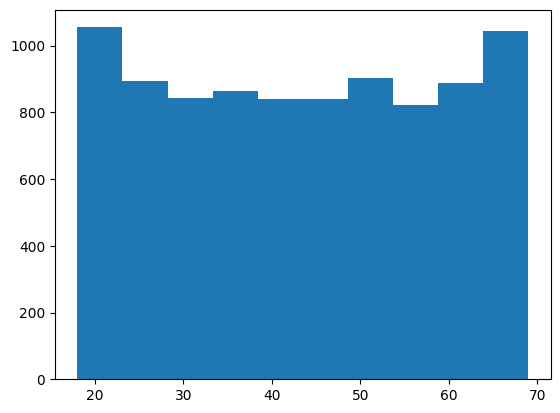

In [13]:
#Create a histogram of the age column
plt.hist(merged_df['age'])

In [14]:
# Find rows with missing age values
missing_age_rows = merged_df[merged_df['age'].isnull()]

# Print the first 20 rows with missing age values
print(missing_age_rows.head(20))

             join_date last_purchase_date  age  gender           location  \
customer_id                                                                 
2           2021-09-08         2023-10-25  NaN    Male          Hillville   
3           2021-06-01         2022-11-27  NaN     NaN   North Latoyatown   
5           2022-01-24         2023-06-02  NaN    Male   East Matthewfort   
7           2023-12-11         2024-05-29  NaN  Female          Perezside   
16          2023-05-06         2023-08-15  NaN    Male        South Laura   
19          2021-03-11         2023-06-05  NaN  Female  New Nicholasville   
38          2023-02-27         2024-03-30  NaN  Female          Tammybury   
39          2022-12-11         2023-01-26  NaN  Female   East Mathewshire   
52          2023-12-29         2024-03-06  NaN  Female    Port Andreatown   
67          2020-08-03         2020-08-17  NaN  Female       Jenniferfurt   
71          2022-07-19         2023-11-10  NaN  Female       North Thomas   

In [15]:
#create a copy of the dataframe
df_train = merged_df.copy()

In [16]:
#since the percentage of missing values in the age is 10%, we can impute the missing values with a measure of central tendency
#since the distribution of the age column follows a fairly uniform distribution, we can use the median to impute the missing values
age_median = df_train['age'].median()
df_train['age'] = df_train['age'].fillna(age_median)

In [17]:
# Print the first 20 rows with missing gender values

missing_gender_rows = df_train[df_train['gender'].isnull()]
print(missing_gender_rows.head(20))

             join_date last_purchase_date   age gender           location  \
customer_id                                                                 
3           2021-06-01         2022-11-27  44.0    NaN   North Latoyatown   
10          2021-08-28         2023-01-08  49.0    NaN       Lake Natasha   
36          2023-06-19         2024-04-05  26.0    NaN       North Kelsey   
66          2024-04-30         2024-05-25  43.0    NaN    South Adammouth   
94          2023-01-04         2024-01-06  48.0    NaN      Port Wandaton   
112         2021-08-03         2023-06-24  44.0    NaN          Anneville   
134         2021-01-01         2021-09-06  33.0    NaN        Thomasville   
174         2023-04-30         2023-11-19  30.0    NaN        Coopermouth   
185         2021-11-03         2022-03-15  31.0    NaN     Port Christina   
187         2020-10-22         2021-07-04  22.0    NaN   West Williamtown   
207         2024-02-23         2024-03-17  24.0    NaN          Greenland   

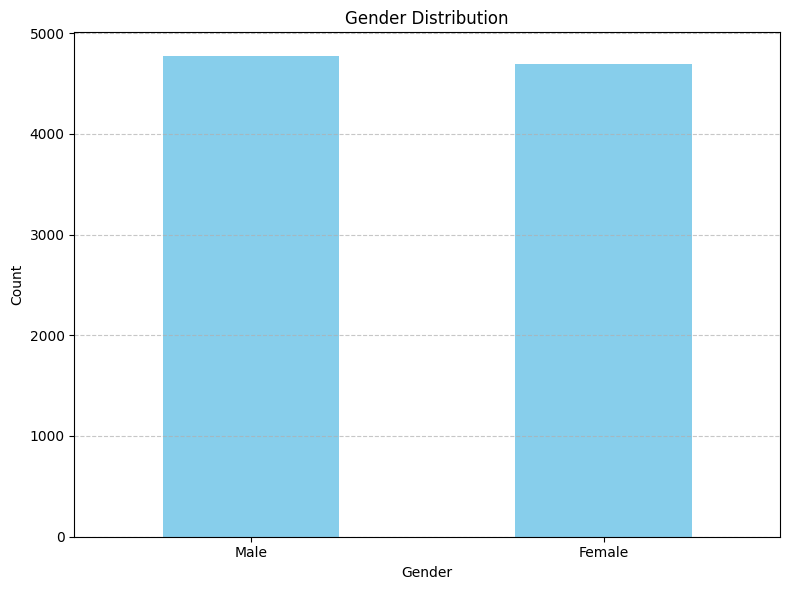

In [18]:
#create a bar chart for gender column only
# Count values in 'gender' column
gender_counts = df_train['gender'].value_counts()

# Plotting a bar chart
plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar', color='skyblue')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
# Find rows with missing gender values
missing_gender_rows = df_train[df_train['gender'].isnull()]

# Print the first 20 rows with missing gender values
print(missing_gender_rows.head(20))

             join_date last_purchase_date   age gender           location  \
customer_id                                                                 
3           2021-06-01         2022-11-27  44.0    NaN   North Latoyatown   
10          2021-08-28         2023-01-08  49.0    NaN       Lake Natasha   
36          2023-06-19         2024-04-05  26.0    NaN       North Kelsey   
66          2024-04-30         2024-05-25  43.0    NaN    South Adammouth   
94          2023-01-04         2024-01-06  48.0    NaN      Port Wandaton   
112         2021-08-03         2023-06-24  44.0    NaN          Anneville   
134         2021-01-01         2021-09-06  33.0    NaN        Thomasville   
174         2023-04-30         2023-11-19  30.0    NaN        Coopermouth   
185         2021-11-03         2022-03-15  31.0    NaN     Port Christina   
187         2020-10-22         2021-07-04  22.0    NaN   West Williamtown   
207         2024-02-23         2024-03-17  24.0    NaN          Greenland   

In [20]:
#fill the missing gender values with unknown
df_train['gender'].fillna('unknown', inplace=True)

print(df_train.head())

             join_date last_purchase_date   age   gender           location  \
customer_id                                                                   
1           2023-11-20         2024-03-17  56.0   Female  North Shannonbury   
2           2021-09-08         2023-10-25  44.0     Male          Hillville   
3           2021-06-01         2022-11-27  44.0  unknown   North Latoyatown   
4           2022-01-01         2022-09-01  29.0     Male          Grossstad   
5           2022-01-24         2023-06-02  44.0     Male   East Matthewfort   

             number_of_site_visits  number_of_emails_opened  number_of_clicks  \
customer_id                                                                     
1                               10                       15                 1   
2                              285                       49                51   
3                              192                       73                25   
4                              110       

C:\Users\User\AppData\Local\Temp\ipykernel_48844\1989472642.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['gender'].fillna('unknown', inplace=True)


In [21]:
#check the percentage of missing values in each numerical column to two decimal places
missing_values = df_train.isnull().sum()
missing_values_percentage = (missing_values/len(df_train))*100
print(missing_values_percentage)

join_date                   0.00
last_purchase_date          0.00
age                         0.00
gender                      0.00
location                    0.00
number_of_site_visits       0.00
number_of_emails_opened     0.00
number_of_clicks            0.00
transaction_id              0.00
transaction_amount          0.00
campaign_id                23.35
dtype: float64


1)EDA

Univariate Analysis

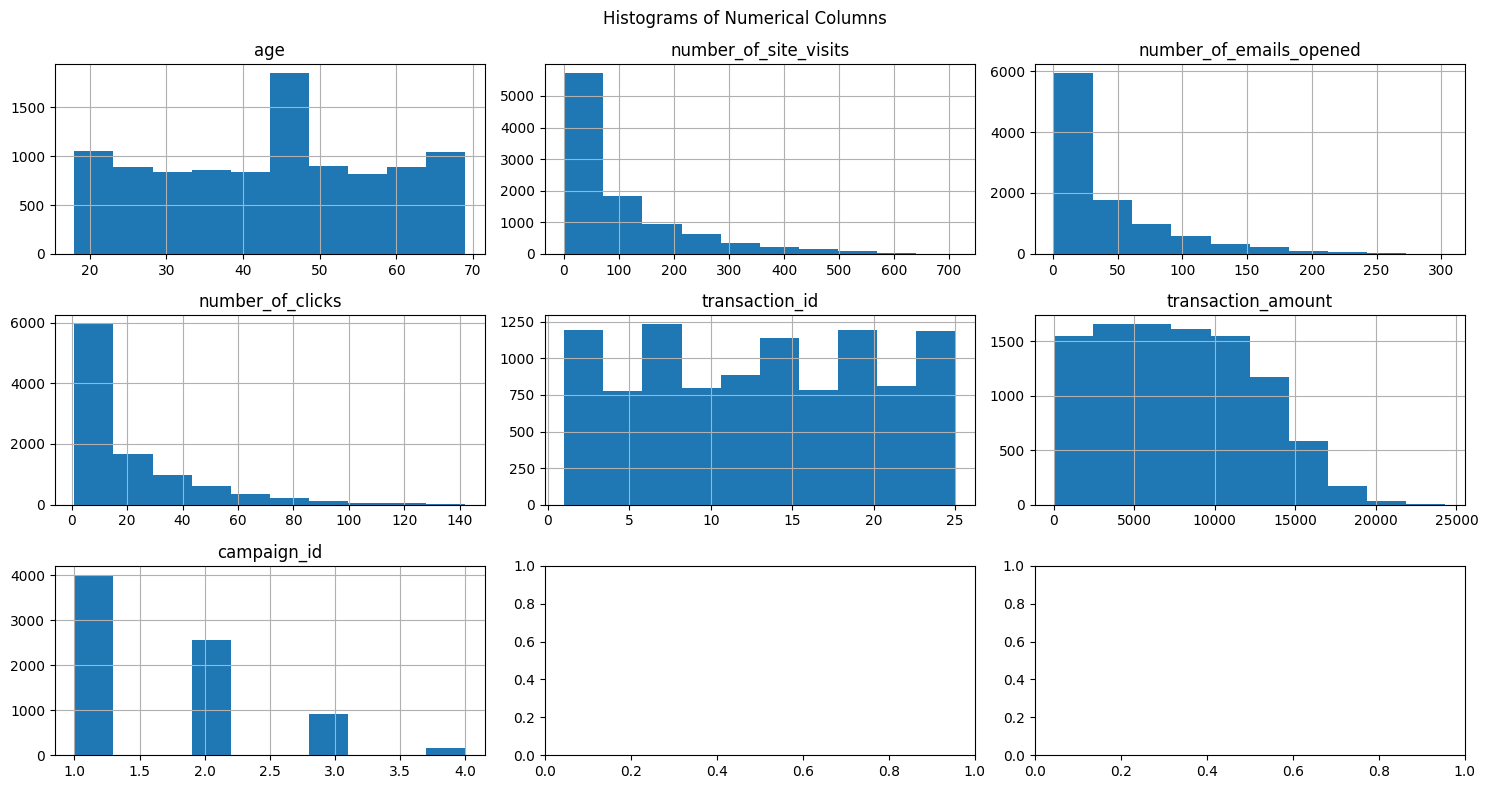

In [22]:
#histograms for all numerical columns as subplots
numerical_columns = df_train.select_dtypes(include=['int64', 'float64']).columns
num_plots = len(numerical_columns)
num_rows = (num_plots - 1) //3 + 1
num_cols = min(num_plots, 3)  
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
fig.suptitle('Histograms of Numerical Columns')
for i, col in enumerate(numerical_columns):
    df_train[col].hist(ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(col)
plt.tight_layout()
plt.show()

In [23]:
#summary statistics for numerical features
numerical_columns = df_train.describe()
print(summary)

               age  number_of_site_visits  number_of_emails_opened  \
count  8991.000000           10000.000000             10000.000000   
mean     43.467467             100.111900                39.862100   
std      15.094380             118.625052                46.511719   
min      18.000000               1.000000                 1.000000   
25%      30.000000              15.000000                 6.000000   
50%      44.000000              53.000000                22.000000   
75%      57.000000             141.000000                57.000000   
max      69.000000             711.000000               303.000000   

       number_of_clicks  transaction_id  transaction_amount  campaign_id  
count      10000.000000    10000.000000        10000.000000  7665.000000  
mean          19.725300       12.954500         7737.562981     1.640965  
std           22.975083        7.191203         4628.799469     0.776240  
min            1.000000        1.000000           23.810000     1.000

<Figure size 640x480 with 0 Axes>

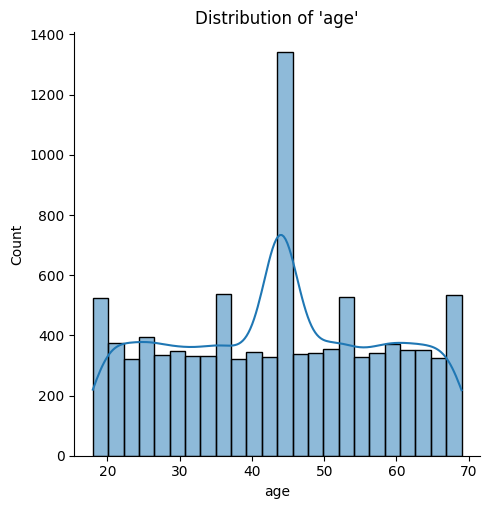

<Figure size 640x480 with 0 Axes>

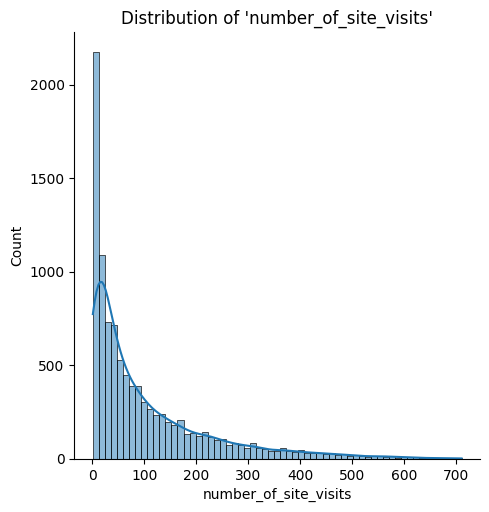

<Figure size 640x480 with 0 Axes>

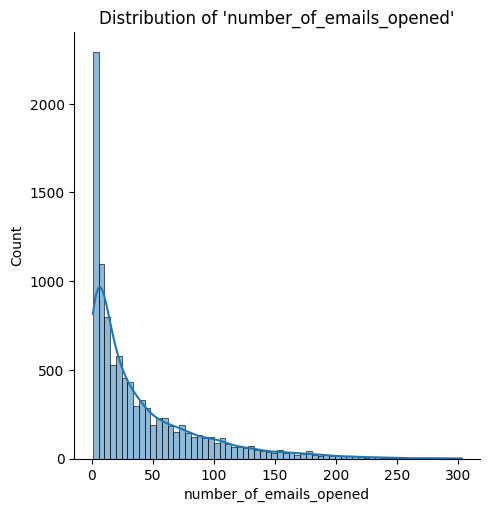

<Figure size 640x480 with 0 Axes>

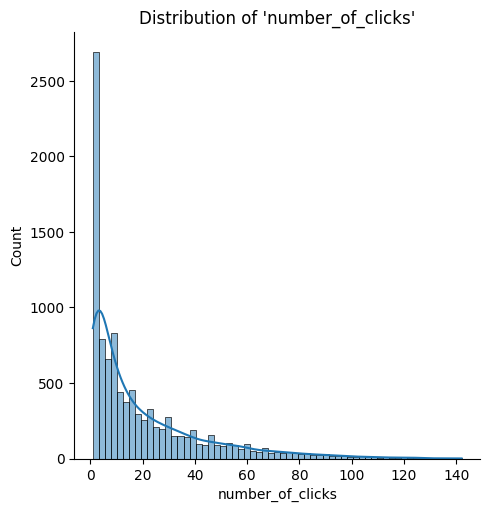

<Figure size 640x480 with 0 Axes>

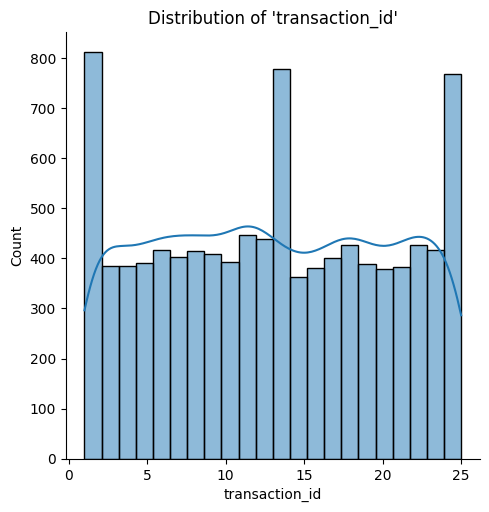

<Figure size 640x480 with 0 Axes>

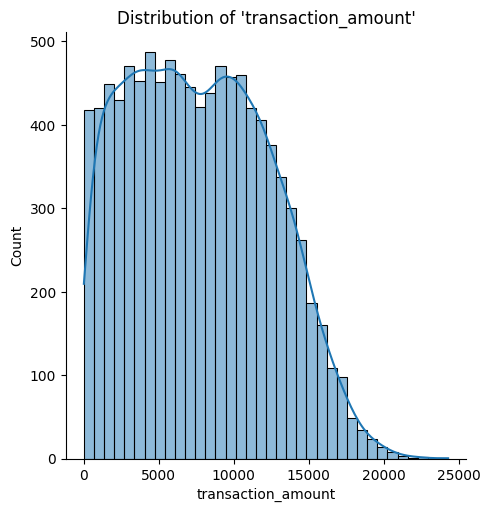

<Figure size 640x480 with 0 Axes>

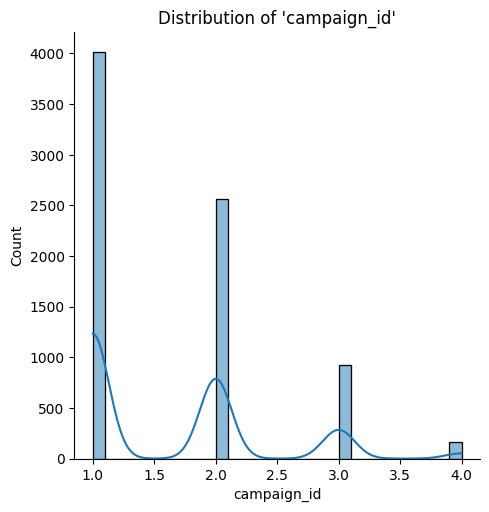

In [24]:
# Plot distributions using seaborn's displot
for col in df_train.select_dtypes(include=['number']).columns:
    plt.figure()
    sns.displot(df_train[col], kde=True)
    plt.title(f"Distribution of '{col}'")
    plt.show()

In [25]:
#Percentage distribution for categorical variables
categorical_summary = df_train.describe(include=['object'])
categorical_summary = categorical_summary.T 
categorical_summary['percentage'] = categorical_summary['freq']/categorical_summary['count']*100
print(categorical_summary)

          count unique         top  freq percentage
gender    10000      3        Male  4769      47.69
location  10000   7695  Lake James    15       0.15


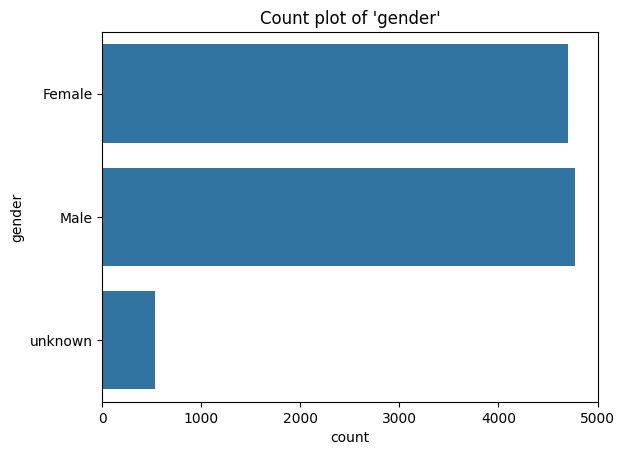

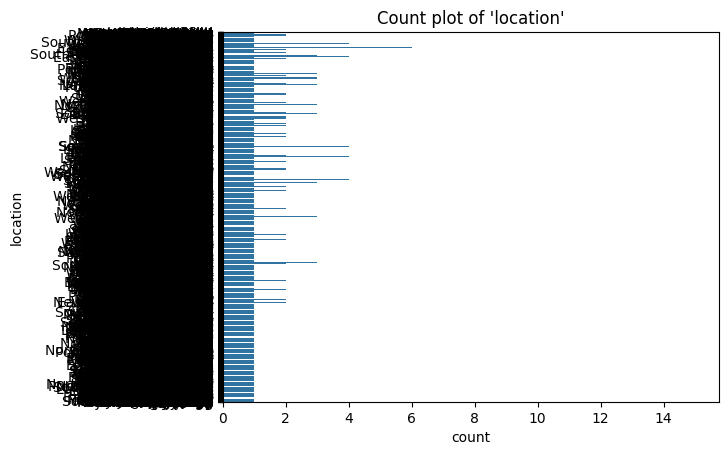

In [26]:
#boxplots for categorical variables
for col in df_train.select_dtypes(include=['object']).columns:
    plt.figure()
    sns.countplot(data=df_train, y=col)
    plt.title(f"Count plot of '{col}'")
    plt.show()

FEATURE ENGINEERING

Encode categorical variables

In [27]:
# Encode categorical data (if any) and convert dates to numerical values

# Using pd.get_dummies to convert categorical variables to dummy variables
gender_dummies = pd.get_dummies(df_train['gender'],dtype=int)
location_dummies = pd.get_dummies(df_train['location'],dtype=int)
                                  
#adding back to the dataframe
df_train = pd.concat([df_train, gender_dummies],axis=1)
                       
df_train = pd.concat([df_train, location_dummies],axis=1)


recency 

In [28]:
# Calculate first and last transaction dates for each customer
recency_data = df_train.groupby('customer_id').agg(join_date=('join_date', 'min'), last_purchase_date=('last_purchase_date', 'max'))

# Calculate the recency as the difference between the last transaction in the data and the last transaction for each customer
max_transaction_date = df_train['last_purchase_date'].max()
recency_data['recency'] = (max_transaction_date - recency_data['last_purchase_date']).dt.days  # convert timedelta to days

# Reset the index to make 'customer_id' a column again
recency_df = recency_data.reset_index()

print(recency_df.head())

recency_df

   customer_id  join_date last_purchase_date  recency
0            1 2023-11-20         2024-03-17       75
1            2 2021-09-08         2023-10-25      219
2            3 2021-06-01         2022-11-27      551
3            4 2022-01-01         2022-09-01      638
4            5 2022-01-24         2023-06-02      364


,customer_id,join_date,last_purchase_date,recency
0,1,2023-11-20,2024-03-17,75
1,2,2021-09-08,2023-10-25,219
2,3,2021-06-01,2022-11-27,551
3,4,2022-01-01,2022-09-01,638
4,5,2022-01-24,2023-06-02,364
...,...,...,...,...
9995,9996,2022-12-16,2023-08-13,292
9996,9997,2022-07-09,2023-01-25,492
9997,9998,2023-09-17,2024-01-30,122
9998,9999,2022-05-10,2022-07-15,686


frequency

In [29]:
# Calculate the total number of transactions per customer using value_counts
frequency_series = df_train['transaction_id'].value_counts()

# Create a DataFrame from the Series
frequency_df = frequency_series.reset_index()
frequency_df.columns = ['customer_id', 'frequency']

# Display the first few rows of the frequency DataFrame
print(frequency_df)

    customer_id  frequency
0            11        446
1            12        438
2            18        427
3            22        426
4             6        417
5            23        416
6             8        415
7             2        411
8             9        408
9             7        403
10           13        402
11            1        401
12           17        401
13           10        392
14            5        391
15           19        389
16           25        386
17            3        385
18            4        384
19           21        383
20           24        383
21           16        380
22           20        378
23           14        376
24           15        362


monetary

In [30]:
# Calculate the mean transaction amount per customer
monetary_data = df_train.groupby('customer_id')['transaction_amount'].mean().reset_index()

# Rename the columns for clarity
monetary_data.columns = ['customer_id', 'monetary']

# Display the first few rows of the monetary DataFrame
print(monetary_data.head())
monetary_data

   customer_id  monetary
0            1   3509.48
1            2   6081.32
2            3   1454.87
3            4   7874.68
4            5  15524.55


,customer_id,monetary
0,1,3509.48
1,2,6081.32
2,3,1454.87
3,4,7874.68
4,5,15524.55
...,...,...
9995,9996,5498.20
9996,9997,5848.30
9997,9998,3503.13
9998,9999,6721.86


rfm

In [31]:
# Merge recency dataframe with frequency dataframe 
temp_df = recency_df.merge(frequency_df, on='customer_id')

# Check the head of the merged DataFrame
print("Merged Recency and Frequency DataFrames:")
print(temp_df.head())

# Merge with monetary dataframe to get a table with the 3 RFM columns
rfm_df = temp_df.merge(monetary_data, on='customer_id')

# Use CustomerID as the index
rfm_df.set_index('customer_id', inplace=True)

# Display the top rows of the final RFM DataFrame to check
print("Final RFM Table:")
print(rfm_df.head())

Merged Recency and Frequency DataFrames:
   customer_id  join_date last_purchase_date  recency  frequency
0            1 2023-11-20         2024-03-17       75        401
1            2 2021-09-08         2023-10-25      219        411
2            3 2021-06-01         2022-11-27      551        385
3            4 2022-01-01         2022-09-01      638        384
4            5 2022-01-24         2023-06-02      364        391
Final RFM Table:
             join_date last_purchase_date  recency  frequency  monetary
customer_id                                                            
1           2023-11-20         2024-03-17       75        401   3509.48
2           2021-09-08         2023-10-25      219        411   6081.32
3           2021-06-01         2022-11-27      551        385   1454.87
4           2022-01-01         2022-09-01      638        384   7874.68
5           2022-01-24         2023-06-02      364        391  15524.55


RFM SCORE

In [32]:
# Rank each metric R , F & M
rfm_df['R_rank'] = rfm_df['recency'].rank( ascending=False)
rfm_df['F_rank'] = rfm_df['frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['monetary'].rank(ascending=True)
rfm_df.head()
# normalize each rank with Max rank
rfm_df['R_rank_norm']=(rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm']=(rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm']=(rfm_df['F_rank']/rfm_df['M_rank'].max())*100
rfm_df.head()
# Now apply our equation and create final score **Consolidated Score = 0.15*R_rank_norm + 0.28*F_rank_norm + 0.57M_rank_norm**
rfm_df['RFM_Score']=0.15*rfm_df['R_rank_norm']+0.28*rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df=rfm_df.round(0)
rfm_df.head()

,join_date,last_purchase_date,recency,frequency,monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
customer_id,,,,,,,,,,,,
1,2023-11-20,2024-03-17,75,401,3509.0,22.0,14.0,9.0,88.0,54.0,54.0,59.0
2,2021-09-08,2023-10-25,219,411,6081.0,18.0,18.0,12.0,72.0,72.0,72.0,72.0
3,2021-06-01,2022-11-27,551,385,1455.0,6.0,8.0,4.0,24.0,32.0,32.0,31.0
4,2022-01-01,2022-09-01,638,384,7875.0,5.0,7.0,15.0,20.0,28.0,28.0,27.0
5,2022-01-24,2023-06-02,364,391,15525.0,12.0,11.0,25.0,48.0,44.0,44.0,45.0


Customer Segment

In [33]:
#Customer segments with RFM Model
#  Segment customers based on RFM score
# 0 - 50 - Low valued customer
# 50 - 75 - Medium valued customer
# 76 - 100 - High valued customer
rfm_df["Customer_segment"]=np.where(rfm_df['RFM_Score'] > 75 ,"High Value Customer",(np.where(rfm_df['RFM_Score'] < 50 , "Low value Customer" ,"Medium Value Customer")))


rfm_df

,join_date,last_purchase_date,recency,frequency,monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
customer_id,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,75,401,3509.0,22.0,14.0,9.0,88.0,54.0,54.0,59.0,Medium Value Customer
2,2021-09-08,2023-10-25,219,411,6081.0,18.0,18.0,12.0,72.0,72.0,72.0,72.0,Medium Value Customer
3,2021-06-01,2022-11-27,551,385,1455.0,6.0,8.0,4.0,24.0,32.0,32.0,31.0,Low value Customer
4,2022-01-01,2022-09-01,638,384,7875.0,5.0,7.0,15.0,20.0,28.0,28.0,27.0,Low value Customer
5,2022-01-24,2023-06-02,364,391,15525.0,12.0,11.0,25.0,48.0,44.0,44.0,45.0,Low value Customer
6,2022-01-01,2023-02-10,476,417,10254.0,9.0,21.0,18.0,36.0,84.0,84.0,77.0,High Value Customer
7,2023-12-11,2024-05-29,2,403,1340.0,25.0,16.0,3.0,100.0,64.0,64.0,69.0,Medium Value Customer
8,2023-02-09,2023-08-09,296,415,11711.0,15.0,19.0,22.0,60.0,76.0,76.0,74.0,Medium Value Customer
9,2022-01-24,2023-08-15,290,408,10383.0,16.0,17.0,19.0,66.0,68.0,68.0,68.0,Medium Value Customer


Merging all columns with RFM data

In [34]:
#Create Total Revenue DataFrame
total_revenue_df = df_train.groupby('customer_id')['transaction_amount'].sum().reset_index()
total_revenue_df.columns = ['customer_id', 'total_revenue']

# Merge recency with clv data
clv_df = total_revenue_df.merge(recency_df, on='customer_id')

# Merge monetary with clv data
clv_df = clv_df.merge(monetary_data, on='customer_id')

#add age, gender, location, number_of_clicks, number_of_site_visits, and	number_of_emails_opened	columns to the clv_df

# Group by customer_id to get unique rows for remaining columns
remaining_columns_df = df_train.groupby('customer_id').agg({
    'age': 'first',
    'gender': 'first',
    'location': 'first',
    'number_of_clicks': 'sum',
    'number_of_site_visits': 'sum',
    'number_of_emails_opened': 'sum'
}).reset_index()

# Merge the remaining columns into clv_df
clv_df = clv_df.merge(remaining_columns_df, on='customer_id')

# Display the first few rows of the final CLV DataFrame
print(clv_df)

      customer_id  total_revenue  join_date last_purchase_date  recency  \
0               1        3509.48 2023-11-20         2024-03-17       75   
1               2        6081.32 2021-09-08         2023-10-25      219   
2               3        1454.87 2021-06-01         2022-11-27      551   
3               4        7874.68 2022-01-01         2022-09-01      638   
4               5       15524.55 2022-01-24         2023-06-02      364   
...           ...            ...        ...                ...      ...   
9995         9996        5498.20 2022-12-16         2023-08-13      292   
9996         9997        5848.30 2022-07-09         2023-01-25      492   
9997         9998        3503.13 2023-09-17         2024-01-30      122   
9998         9999        6721.86 2022-05-10         2022-07-15      686   
9999        10000        5775.83 2023-05-26         2023-09-01      273   

      monetary   age   gender           location  number_of_clicks  \
0      3509.48  56.0   Female

Engagement Score
Merge engagement score with all columns

In [35]:
# Aggregate engagement features
engagement_features = df_train.groupby('customer_id').agg({
    'number_of_site_visits': 'sum',
    'number_of_emails_opened': 'sum',
    'number_of_clicks': 'sum'
}).reset_index()

# Create a numerical engagement score by summing the engagement features
engagement_features['engagement_score'] = (
    engagement_features['number_of_site_visits'] +
    engagement_features['number_of_emails_opened'] +
    engagement_features['number_of_clicks']
)

# Display the engagement features with the engagement score
print(engagement_features)
# Merge engagement features into clv_df
clv_df = clv_df.merge(engagement_features, on='customer_id')

      customer_id  number_of_site_visits  number_of_emails_opened  \
0               1                     10                       15   
1               2                    285                       49   
2               3                    192                       73   
3               4                    110                       30   
4               5                    161                        2   
...           ...                    ...                      ...   
9995         9996                    119                       47   
9996         9997                      3                       33   
9997         9998                     53                       17   
9998         9999                     23                        5   
9999        10000                     12                       12   

      number_of_clicks  engagement_score  
0                    1                26  
1                   51               385  
2                   25               290  

CLV Calculation

In [36]:
# Calculate the duration in days between first and last transactions (customer lifetime)
clv_df['clv'] = (clv_df['last_purchase_date'] - clv_df['join_date']).dt.days

print(clv_df['clv'])

0       118
1       777
2       544
3       243
4       494
       ... 
9995    240
9996    200
9997    135
9998     66
9999     98
Name: clv, Length: 10000, dtype: int64


In [37]:
#merge the clv_df with rfm_df
clvrfm_df = clv_df.merge(rfm_df, on='customer_id')

clvrfm_df

,customer_id,total_revenue,join_date_x,last_purchase_date_x,recency_x,monetary_x,age,gender,location,number_of_clicks_x,...,frequency,monetary_y,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
0,1,3509.48,2023-11-20,2024-03-17,75,3509.48,56.0,Female,North Shannonbury,1,...,401,3509.0,22.0,14.0,9.0,88.0,54.0,54.0,59.0,Medium Value Customer
1,2,6081.32,2021-09-08,2023-10-25,219,6081.32,44.0,Male,Hillville,51,...,411,6081.0,18.0,18.0,12.0,72.0,72.0,72.0,72.0,Medium Value Customer
2,3,1454.87,2021-06-01,2022-11-27,551,1454.87,44.0,unknown,North Latoyatown,25,...,385,1455.0,6.0,8.0,4.0,24.0,32.0,32.0,31.0,Low value Customer
3,4,7874.68,2022-01-01,2022-09-01,638,7874.68,29.0,Male,Grossstad,17,...,384,7875.0,5.0,7.0,15.0,20.0,28.0,28.0,27.0,Low value Customer
4,5,15524.55,2022-01-24,2023-06-02,364,15524.55,44.0,Male,East Matthewfort,7,...,391,15525.0,12.0,11.0,25.0,48.0,44.0,44.0,45.0,Low value Customer
5,6,10254.44,2022-01-01,2023-02-10,476,10254.44,55.0,Female,North Richardfort,7,...,417,10254.0,9.0,21.0,18.0,36.0,84.0,84.0,77.0,High Value Customer
6,7,1339.82,2023-12-11,2024-05-29,2,1339.82,44.0,Female,Perezside,6,...,403,1340.0,25.0,16.0,3.0,100.0,64.0,64.0,69.0,Medium Value Customer
7,8,11710.62,2023-02-09,2023-08-09,296,11710.62,68.0,Male,Marquezton,7,...,415,11711.0,15.0,19.0,22.0,60.0,76.0,76.0,74.0,Medium Value Customer
8,9,10382.96,2022-01-24,2023-08-15,290,10382.96,68.0,Female,West Franciscobury,21,...,408,10383.0,16.0,17.0,19.0,66.0,68.0,68.0,68.0,Medium Value Customer
9,10,745.28,2021-08-28,2023-01-08,509,745.28,49.0,unknown,Lake Natasha,24,...,392,745.0,7.0,12.0,1.0,28.0,48.0,48.0,45.0,Low value Customer


In [38]:
print(clv_df)

      customer_id  total_revenue  join_date last_purchase_date  recency  \
0               1        3509.48 2023-11-20         2024-03-17       75   
1               2        6081.32 2021-09-08         2023-10-25      219   
2               3        1454.87 2021-06-01         2022-11-27      551   
3               4        7874.68 2022-01-01         2022-09-01      638   
4               5       15524.55 2022-01-24         2023-06-02      364   
...           ...            ...        ...                ...      ...   
9995         9996        5498.20 2022-12-16         2023-08-13      292   
9996         9997        5848.30 2022-07-09         2023-01-25      492   
9997         9998        3503.13 2023-09-17         2024-01-30      122   
9998         9999        6721.86 2022-05-10         2022-07-15      686   
9999        10000        5775.83 2023-05-26         2023-09-01      273   

      monetary   age   gender           location  number_of_clicks_x  \
0      3509.48  56.0   Fema

2) Visualisations

CLV Distribution

[Text(0.5, 0, 'clv'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'clv Boxplot Distribution')]

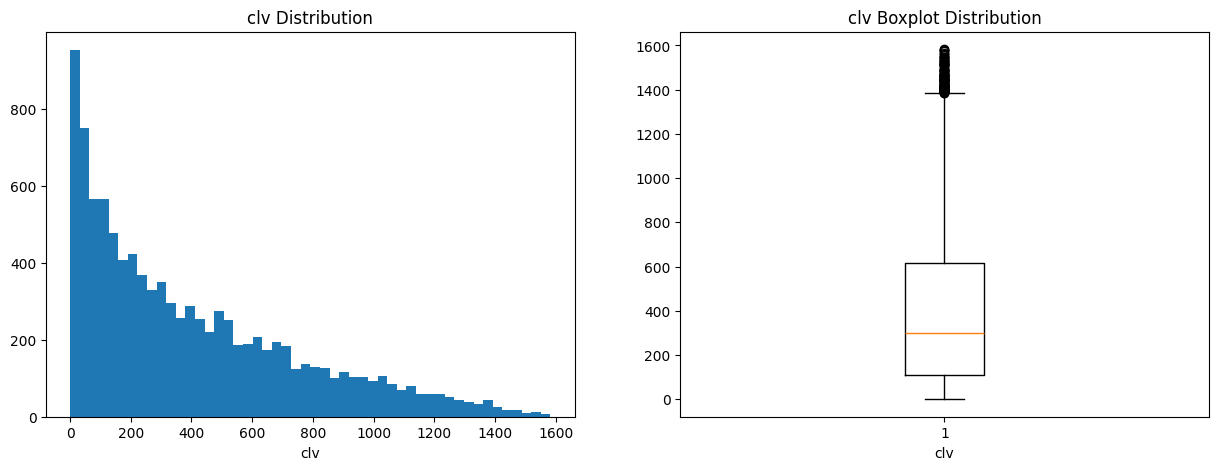

In [39]:
fig, axs = plt.subplots(1, 2,figsize=(15,5))

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0].hist(clv_df['clv'], bins=50)


# We can also normalize our inputs by the total number of counts
axs[1].boxplot(clv_df['clv'])
axs[0].set(xlabel='clv', ylabel='', title='clv Distribution')
axs[1].set(xlabel='clv', ylabel='', title='clv Boxplot Distribution')

In [40]:
clv_df['clv'].skew()
#from the skewness value, we can see that the lifetime_duration column is positively skewed and from the boxplot we can see that there are outliers in the column but we will not remove them because they are valid data points

0.9700541611257611

From the skewness value, we can see that the lifetime_duration column is positively skewed and from the boxplot we can see that there are outliers in the column but we will not remove them because they are valid data points.

In [41]:


mean = clv_df['clv'].mean()
std = clv_df['clv'].std()

stat, p = kstest(clv_df['clv'], 'norm', args=(mean, std))

print('Kolmogorov-Smirnov Test')
print('Statistic:', stat)
print('p-value:', p)

Kolmogorov-Smirnov Test
Statistic: 0.12900177089414594
p-value: 1.5188772628815417e-145


the p-values is greater than 0.05, we fail to reject the null hypothesis that the lifetime_duration column is normally distributed


Recency Distribution

[Text(0.5, 0, 'recency'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'recency Boxplot Distribution')]

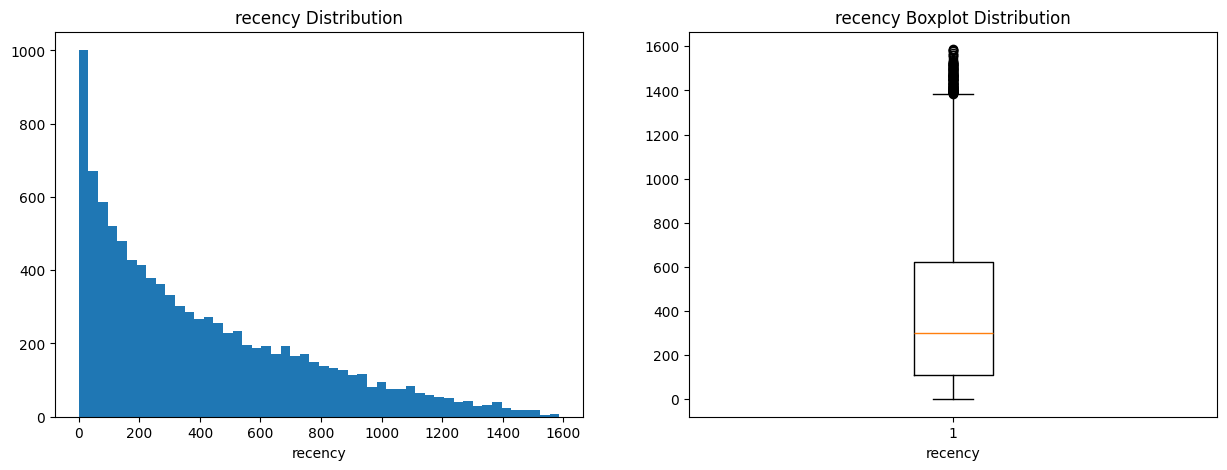

In [42]:
fig, axs = plt.subplots(1, 2,figsize=(15,5))

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0].hist(clv_df['recency'], bins=50)


# We can also normalize our inputs by the total number of counts
axs[1].boxplot(clv_df['recency'])
axs[0].set(xlabel='recency', ylabel='', title='recency Distribution')
axs[1].set(xlabel='recency', ylabel='', title='recency Boxplot Distribution')

In [43]:
clv_df['recency'].skew()

0.9684483405611335

From the recency the skewness value, we can see that the recency column is positively skewed and from the boxplot we can see that there are outliers in the column but we will not remove them because they are valid data points

Engagement Score Distribution

[Text(0.5, 0, 'engagement_score'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Engagement Score Boxplot Distribution')]

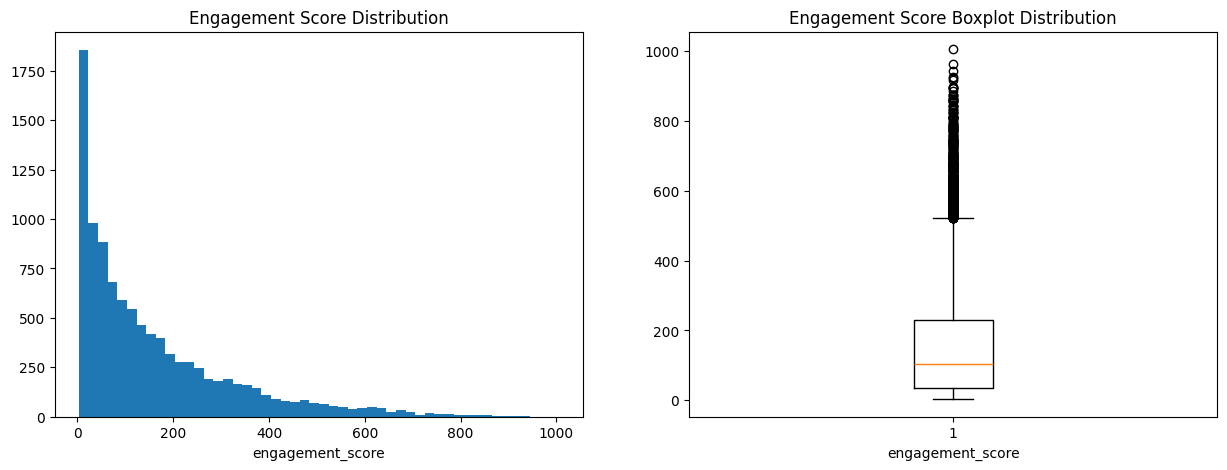

In [44]:
fig, axs = plt.subplots(1, 2,figsize=(15,5))

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0].hist(clv_df['engagement_score'], bins=50)


# We can also normalize our inputs by the total number of counts
axs[1].boxplot(clv_df['engagement_score'])
axs[0].set(xlabel='engagement_score', ylabel='', title='Engagement Score Distribution')
axs[1].set(xlabel='engagement_score', ylabel='', title='Engagement Score Boxplot Distribution')

Frequency Distribution

[Text(0.5, 0, 'frequency'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Frequency Boxplot Distribution')]

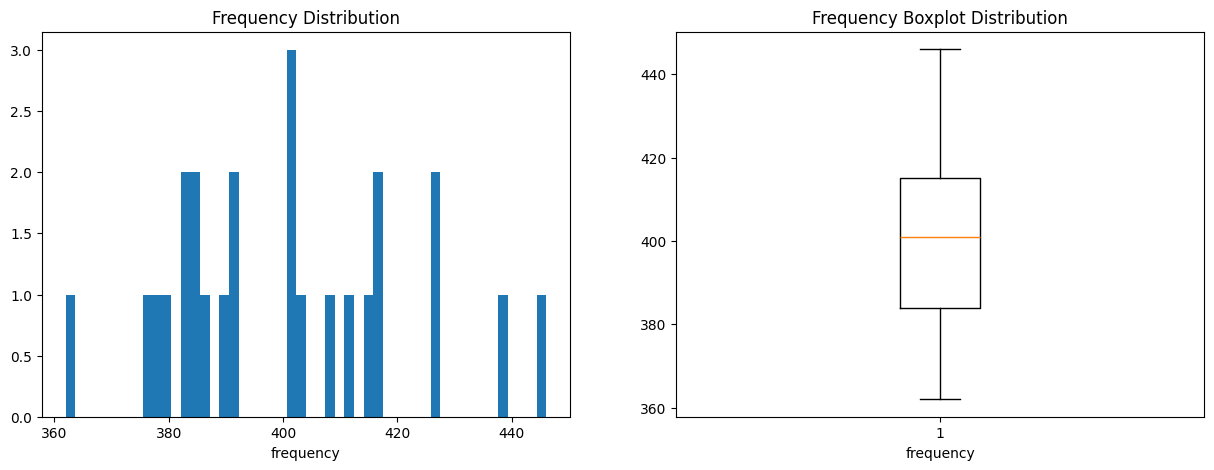

In [45]:
fig, axs = plt.subplots(1, 2,figsize=(15,5))

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0].hist(frequency_df['frequency'], bins=50)


# We can also normalize our inputs by the total number of counts
axs[1].boxplot(frequency_df['frequency'])
axs[0].set(xlabel='frequency', ylabel='', title='Frequency Distribution')
axs[1].set(xlabel='frequency', ylabel='', title='Frequency Boxplot Distribution')



Monetary Distribution

[Text(0.5, 0, 'monetary'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Monetary Boxplot Distribution')]

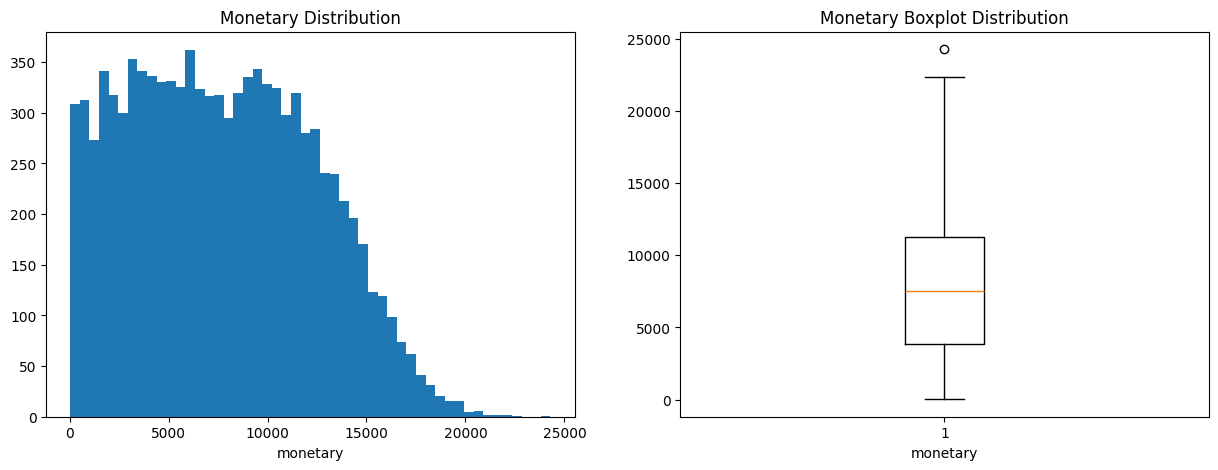

In [46]:
fig, axs = plt.subplots(1, 2,figsize=(15,5))

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0].hist(clv_df['monetary'], bins=50)


# We can also normalize our inputs by the total number of counts
axs[1].boxplot(clv_df['monetary'])
axs[0].set(xlabel='monetary', ylabel='', title='Monetary Distribution')
axs[1].set(xlabel='monetary', ylabel='', title='Monetary Boxplot Distribution')

the monetary distrubution is also positively skewed.

Correlation Matrix

<Axes: >

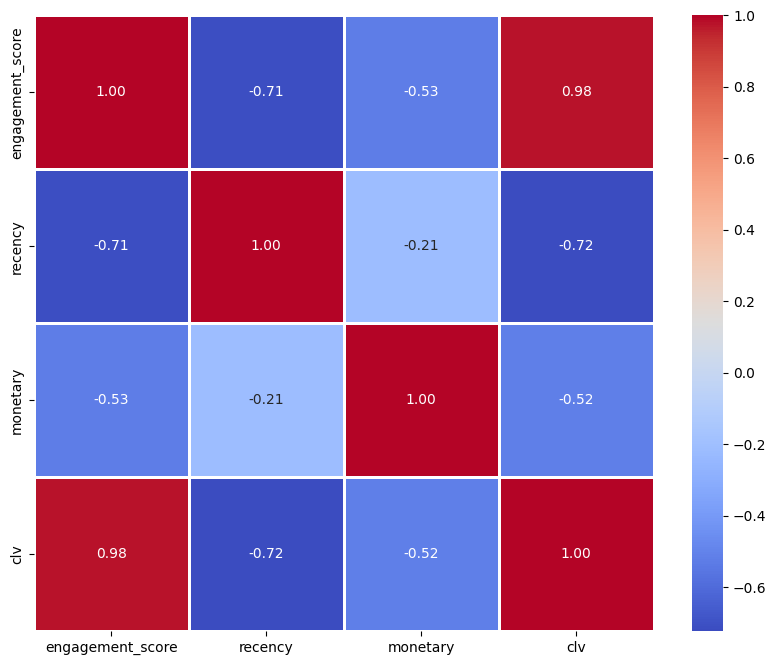

In [47]:
#heatmap for correlation matrix

heatmap=clv_df[['engagement_score','recency', 'monetary', 'clv']].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(heatmap.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)

Plot of feature variable and RFM Score

Distribution of CLV, Customer Segmentation and Age/Gender

<Axes: xlabel='M_rank', ylabel='clv'>

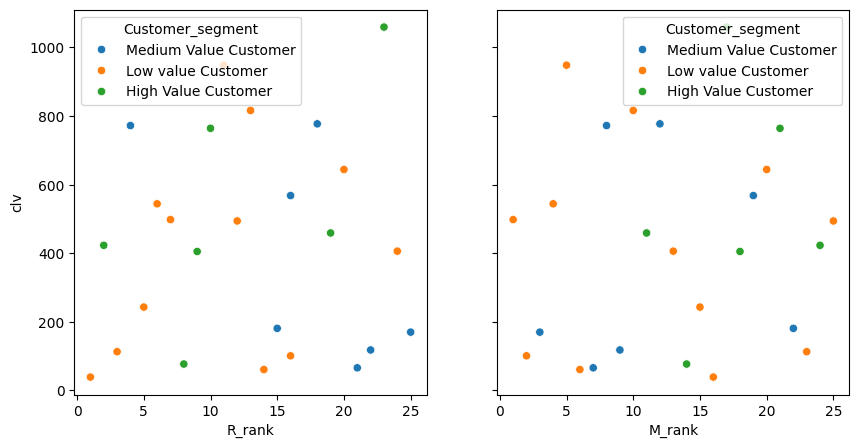

In [48]:
# loan amount distribution
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5), sharey=True)
sns.scatterplot(x='R_rank', y='clv', hue='Customer_segment', data=clvrfm_df, ax=ax1)
sns.scatterplot(x='M_rank', y='clv',hue='Customer_segment', data=clvrfm_df, ax=ax2)

<Axes: xlabel='engagement_score', ylabel='clv'>

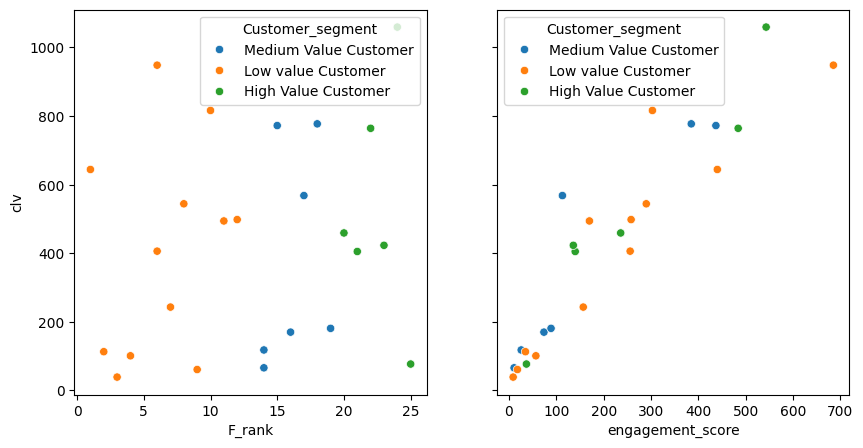

In [49]:
# loan amount distribution
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5), sharey=True)
sns.scatterplot(x='F_rank', y='clv', hue='Customer_segment', data=clvrfm_df, ax=ax1)
sns.scatterplot(x='engagement_score', y='clv',hue='Customer_segment', data=clvrfm_df, ax=ax2)

In [50]:
#make a copy of the clv_df and call it df
df = clvrfm_df.copy()

# Assuming rfm_df is your dataframe with RFM scores, customer segments, CLV, and engagement scores

# Calculate metrics for each segmentation group
metrics_by_segment = df.groupby('Customer_segment').agg({
    'R_rank': 'mean',
    'M_rank': 'mean',
    'F_rank': 'mean',
    'clv': 'mean',  # Assuming you have a CLV_Score column
    'engagement_score': 'mean'  # Assuming you have an Engagement_Score column
})

# Rename columns for clarity
metrics_by_segment.columns = [
    'Avg_Recency',
    'Avg_Monetary',
    'Avg_Frequency',
    'Avg_CLV_Score',
    'Avg_Engagement_Score'
]

# Display the results
print(metrics_by_segment)

# If you want to reset the index to make 'Customer_segment' a column
metrics_by_segment = metrics_by_segment.reset_index()

# If you want to round the results to 2 decimal places
metrics_by_segment = metrics_by_segment.round(2)

print("\nRounded results:")
print(metrics_by_segment)

                       Avg_Recency  Avg_Monetary  Avg_Frequency  \
Customer_segment                                                  
High Value Customer      11.833333     17.500000      22.500000   
Low value Customer       11.000000     11.666667       6.583333   
Medium Value Customer    17.285714     11.428571      16.142857   

                       Avg_CLV_Score  Avg_Engagement_Score  
Customer_segment                                            
High Value Customer       531.166667            262.666667  
Low value Customer        408.916667            223.166667  
Medium Value Customer     378.857143            162.142857  

Rounded results:
        Customer_segment  Avg_Recency  Avg_Monetary  Avg_Frequency  \
0    High Value Customer        11.83         17.50          22.50   
1     Low value Customer        11.00         11.67           6.58   
2  Medium Value Customer        17.29         11.43          16.14   

   Avg_CLV_Score  Avg_Engagement_Score  
0         531.17   

Linear Regression Model

In [66]:
# Prepare the feature matrix and target variable
X = clv_df.drop(['clv'], axis=1)
y = clv_df['clv']

# Fit the linear regression model
results = smf.ols("clv ~ recency + monetary + total_revenue + age + gender + engagement_score", data=clv_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    clv   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     4572.
Date:                Tue, 16 Jul 2024   Prob (F-statistic):               0.00
Time:                        18:37:39   Log-Likelihood:                -66328.
No. Observations:               10000   AIC:                         1.327e+05
Df Residuals:                    9993   BIC:                         1.327e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           114.8942      7.50

In [67]:
#manually calculate the predicted values
# Calculate the predicted values
predicted_values = results.predict(X)

#estimate a predicted value against the actual value
actual_vs_predicted = pd.DataFrame({'Actual': y, 'Predicted': predicted_values})
print(actual_vs_predicted.head())

# Calculate the mean squared error
mse = mean_squared_error(y, predicted_values)
print('Mean Squared Error:', mse)

   Actual   Predicted
0     118  172.867890
1     777  824.112402
2     544  637.605916
3     243  385.774164
4     494  422.365918
Mean Squared Error: 33784.80697391823


this is the OLS regression model for the clv column. The results show a high r-squared value   of 0.73 which means that the model explains 73% of the variance in the target variable. The p-values for all the features,except recency, age and engagement score are greater than 0.05 which means that they are statistically insignificant. 

Checking OLS Assumptions

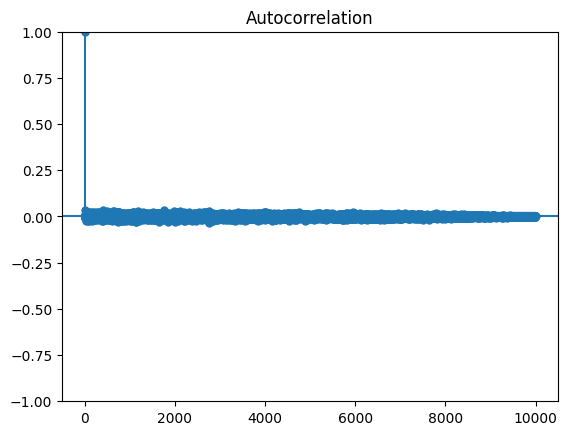

In [53]:


# Use tsaplots to access plot_acf
acf = tsaplots.plot_acf(results.resid, lags=len(results.resid)-1, alpha=0.05)

from the graph we can see no autocorrelation

Residuals Distribution

In [54]:

print(stats.jarque_bera(results.resid))

SignificanceResult(statistic=13077.367346061348, pvalue=0.0)


The model is an ok fit for the data and none of the linear regression assumptions are violated. Let us look at another model to ensure robustness of our CLV prediction.

KNN Regressor

In [55]:
#defining the independent and dependent variables
X = clv_df[['recency', 'monetary', 'engagement_score']]
y = clv_df['clv']

#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


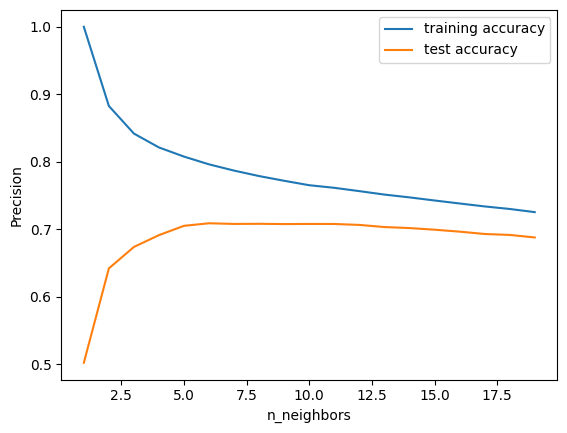

In [56]:
training_precision = []
test_precision = []
# try n_neighbors from 1 to 20
neighbors_settings = range(1, 20)
for n_neighbors in neighbors_settings:
 # build the model
 knn = KNeighborsRegressor(n_neighbors=n_neighbors)
 knn.fit(X_train, y_train)
 # record training set precision
 training_precision.append(knn.score(X_train, y_train))
 # record test set precision
 test_precision.append(knn.score(X_test, y_test))
plt.plot(neighbors_settings, training_precision, label='training accuracy')
plt.plot(neighbors_settings, test_precision, label='test accuracy')
plt.ylabel('Precision')
plt.xlabel('n_neighbors')
plt.legend()
plt.savefig('knn_compare_model')

In [57]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsRegressor()

Confusion Matrix (Precision Tests)

In [60]:
print('Precision of K-NN regressor on training set: {:.3f}'.format(knn.score(X_train, y_train)))
print('Precision of K-NN regressor on test set: {:.3f}'.format(knn.score(X_test, y_test)))
# Calculate the mean squared error and R-squared value
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R-squared value:', r2)


Precision of K-NN regressor on training set: 0.808
Precision of K-NN regressor on test set: 0.705
Mean Squared Error: 36976.89236
R-squared value: 0.7050519951326631


The precision score is 70% which is a good precision. Let us make a CLV prediction using the model.

Predict CLV from the KNN Model

In [61]:
# Update the new_customer input to have the same number of features as the training data
new_customer = [[75,3000,283]]

# Predict the lifetime duration for the new customer
predicted_clv = knn.predict(new_customer)
print('Predicted CLV:', predicted_clv)


Predicted CLV: [1053.]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [62]:
#find an actual customer in the dataset and make predictions
#find an actual customer in the dataset and make predictions
actual_customer = X_test.iloc[0].values.reshape(1, -1)
actual_clv = y_test.iloc[0]

predicted_knn_clv = knn.predict(actual_customer)
print('Actual CLV:', actual_clv)
print('Predicted CLV:', predicted_knn_clv)

Actual CLV: 787
Predicted CLV: [492.8]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [63]:
y_pred_rounded = np.round(y_pred).astype(int)

print('Recall:', recall_score(y_test, y_pred_rounded, average='micro'))
    


Recall: 0.0045


the model has a relatively high precision score but a low recall score which means that the model is good at predicting the positive class but not the negative class. Let us consider one more model before we choose the best model to use for our predictions.

Considering that the clv variable is continuous variable, decision tree regressor captures non-linear relationships without requiring feature scaling. However it is best to use a random forest regressor model as it is an ensemble method that improves the robustness and accuracy of decision trees.

In [64]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline with RandomForest Regressor
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizing the data
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define the parameter grid for RandomForest Regressor
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(rf_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best score for Random Forest:", grid_search_rf.best_score_)

# Make predictions on the testing set
y_pred = grid_search_rf.predict(X_test)



# Calculate the mean squared error and R-squared value
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R-squared value:', r2)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Best score for Random Forest: 0.7772797200531049
Mean Squared Error: 28781.855948055036
R-squared value: 0.7704201070871731


The random forest model has provide the highest R square score out of the three models at 77.7%. 

In [ ]:
#print the precision score
print('Precision of Random Forest regressor on test set: {:.3f}'.format(grid_search_rf.score(X_test, y_test)))

#print recall score
y_pred_rounded = np.round(y_pred).astype(int)
print('Recall:', recall_score(y_test, y_pred_rounded, average='micro'))

Precision of Random Forest regressor on test set: 0.770
Recall: 0.011


In [ ]:

#make new customer predictions with the random forest regressor
new_customer = [[75,3000,283]]
predicted_clv = grid_search_rf.predict(new_customer)
print('Predicted CLV:', predicted_clv)

Predicted CLV: [856.90344315]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [68]:
#find an actual customer in the dataset and make predictions
actual_customer = X_test.iloc[0].values.reshape(1, -1)
actual_clv = y_test.iloc[0]

predicted_actual_clv = grid_search_rf.predict(actual_customer)
print('Actual CLV:', actual_clv)
print('Predicted CLV:', predicted_actual_clv)

#estimate a predicted value against the actual value
actual_vs_predicted = pd.DataFrame({'Actual': actual_clv, 'Predicted': predicted_actual_clv})
print(actual_vs_predicted.head())

Actual CLV: 787
Predicted CLV: [557.94447188]
   Actual   Predicted
0     787  557.944472


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


The precision score for the random forest regressor is the highest out of all the variables. Additionally, the predictions made by the random forest regressor are the closests to the actual clv values and so it is best to use the random forest model to predict CLV for EcomX.